*Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 4 - Building Good Training Sets – Data Preprocessing

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -p numpy,pandas,matplotlib,sklearn

Sebastian Raschka 
last updated: 2018-07-02 

numpy 1.14.5
pandas 0.23.1
matplotlib 2.2.2
sklearn 0.19.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

<br>
<br>

### Overview

- [Dealing with missing data](#Dealing-with-missing-data)
  - [Identifying missing values in tabular data](#Identifying-missing-values-in-tabular-data)
  - [Eliminating samples or features with missing values](#Eliminating-samples-or-features-with-missing-values)
  - [Imputing missing values](#Imputing-missing-values)
  - [Understanding the scikit-learn estimator API](#Understanding-the-scikit-learn-estimator-API)
- [Handling categorical data](#Handling-categorical-data)
  - [Nominal and ordinal features](#Nominal-and-ordinal-features)
  - [Mapping ordinal features](#Mapping-ordinal-features)
  - [Encoding class labels](#Encoding-class-labels)
  - [Performing one-hot encoding on nominal features](#Performing-one-hot-encoding-on-nominal-features)
- [Partitioning a dataset into a separate training and test set](#Partitioning-a-dataset-into-seperate-training-and-test-sets)
- [Bringing features onto the same scale](#Bringing-features-onto-the-same-scale)
- [Selecting meaningful features](#Selecting-meaningful-features)
  - [L1 and L2 regularization as penalties against model complexity](#L1-and-L2-regularization-as-penalties-against-model-omplexity)
  - [A geometric interpretation of L2 regularization](#A-geometric-interpretation-of-L2-regularization)
  - [Sparse solutions with L1 regularization](#Sparse-solutions-with-L1-regularization)
  - [Sequential feature selection algorithms](#Sequential-feature-selection-algorithms)
- [Assessing feature importance with Random Forests](#Assessing-feature-importance-with-Random-Forests)
- [Summary](#Summary)

<br>
<br>

In [2]:
from IPython.display import Image
%matplotlib inline

# Dealing with missing data

## Identifying missing values in tabular data

In [3]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:

if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [5]:
# access the underlying NumPy array
# via the `values` attribute
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

<br>
<br>

## Eliminating samples or features with missing values

In [6]:
# remove rows that contain missing values

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# remove columns that contain missing values

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [8]:
# remove columns that contain missing values

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [9]:
# only drop rows where all columns are NaN

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [10]:
# drop rows that have less than 3 real values 

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [11]:
# only drop rows where NaN appear in specific columns (here: 'C')

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


<br>
<br>

## Imputing missing values

In [12]:
# again: our original array
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [13]:
# impute missing values via the column mean

from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

<br>
<br>

## Understanding the scikit-learn estimator API

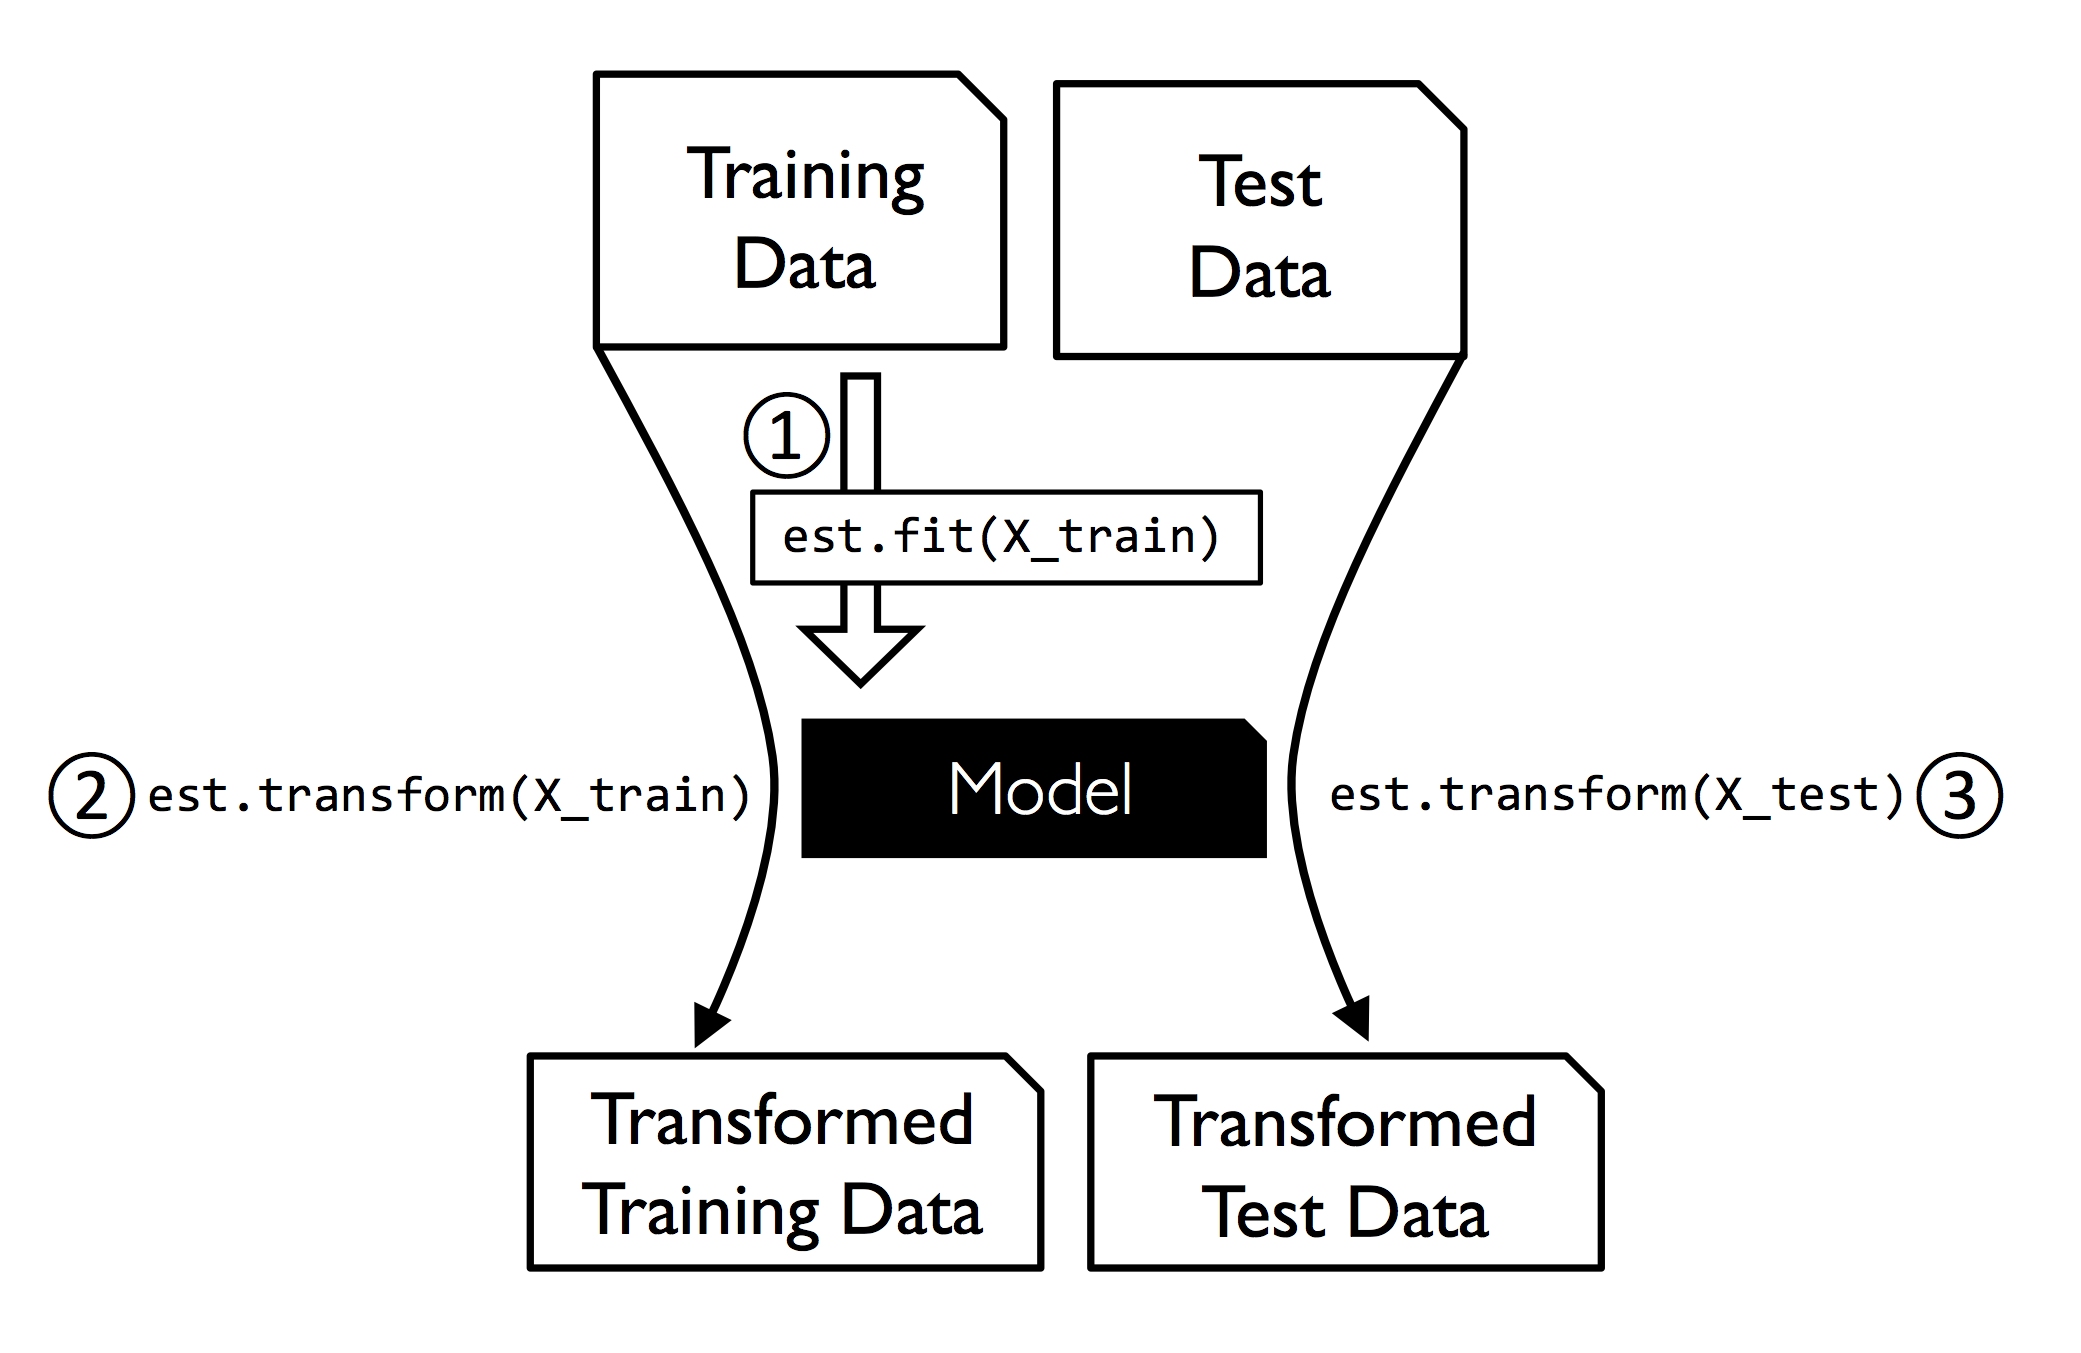

In [14]:
Image(filename='images/04_01.png', width=400) 

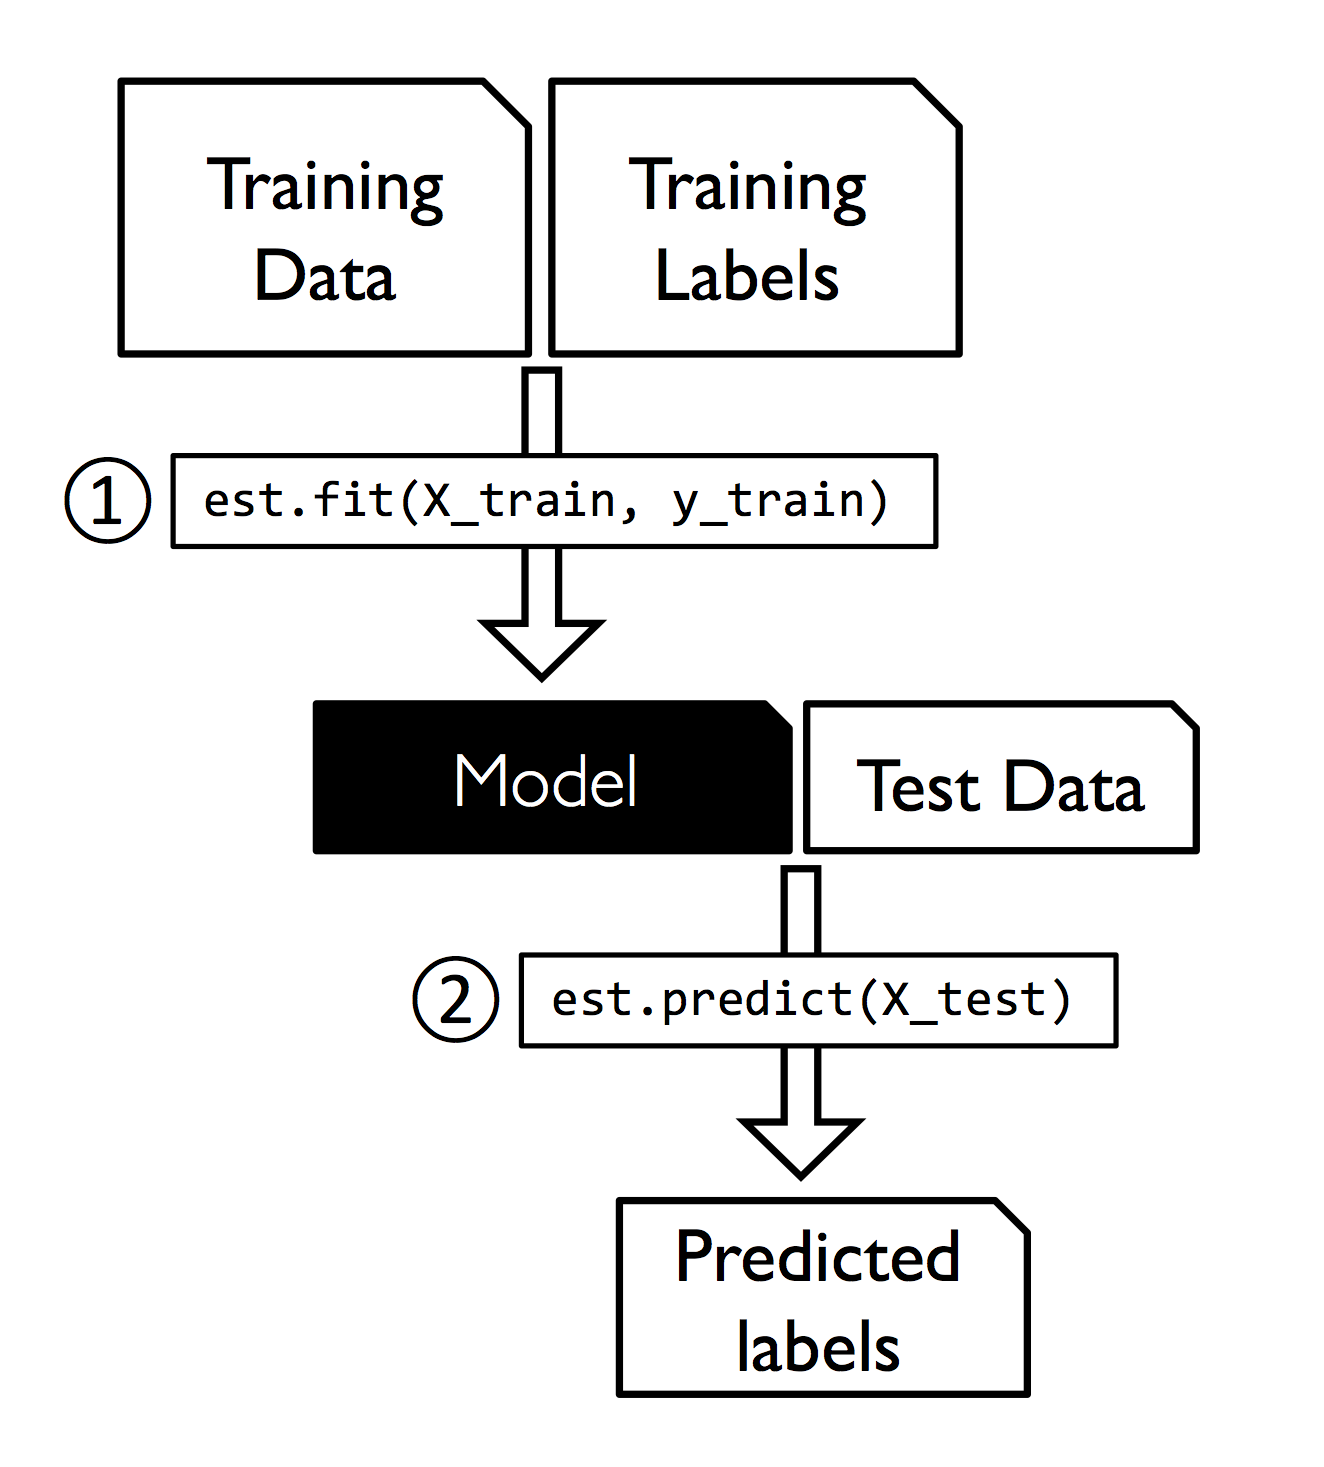

In [15]:
Image(filename='images/04_02.png', width=300) 

<br>
<br>

# Handling categorical data

## Nominal and ordinal features

In [16]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


<br>
<br>

## Mapping ordinal features

In [17]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [18]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

<br>
<br>

## Encoding class labels

In [19]:
import numpy as np

# create a mapping dict
# to convert class labels from strings to integers
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [20]:
# to convert class labels from strings to integers
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [21]:
# reverse the class label mapping
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [22]:
from sklearn.preprocessing import LabelEncoder

# Label encoding with sklearn's LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [23]:
# reverse mapping
class_le.inverse_transform(y)

/Users/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['class2', 'class1', 'class2'], dtype=object)

Note: The deprecation warning shown above is due to an implementation detail in scikit-learn. It was already addressed in a pull request (https://github.com/scikit-learn/scikit-learn/pull/9816), and the patch will be released with the next version of scikit-learn (i.e., v. 0.20.0).

<br>
<br>

## Performing one-hot encoding on nominal features

In [24]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [25]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [26]:
# return dense array so that we can skip
# the toarray step

ohe = OneHotEncoder(categorical_features=[0], sparse=False)
ohe.fit_transform(X)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [27]:
# one-hot encoding via pandas

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [28]:
# multicollinearity guard in get_dummies

pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [29]:
# multicollinearity guard for the OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

<br>
<br>

# Partitioning a dataset into a seperate training and test set

In [30]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [31]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

<br>
<br>

# Bringing features onto the same scale

In [32]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [33]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

A visual example:

In [34]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('standardized:', (ex - ex.mean()) / ex.std())

# Please note that pandas uses ddof=1 (sample standard deviation) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


<br>
<br>

# Selecting meaningful features

...

## L1 and L2 regularization as penalties against model complexity

## A geometric interpretation of L2 regularization

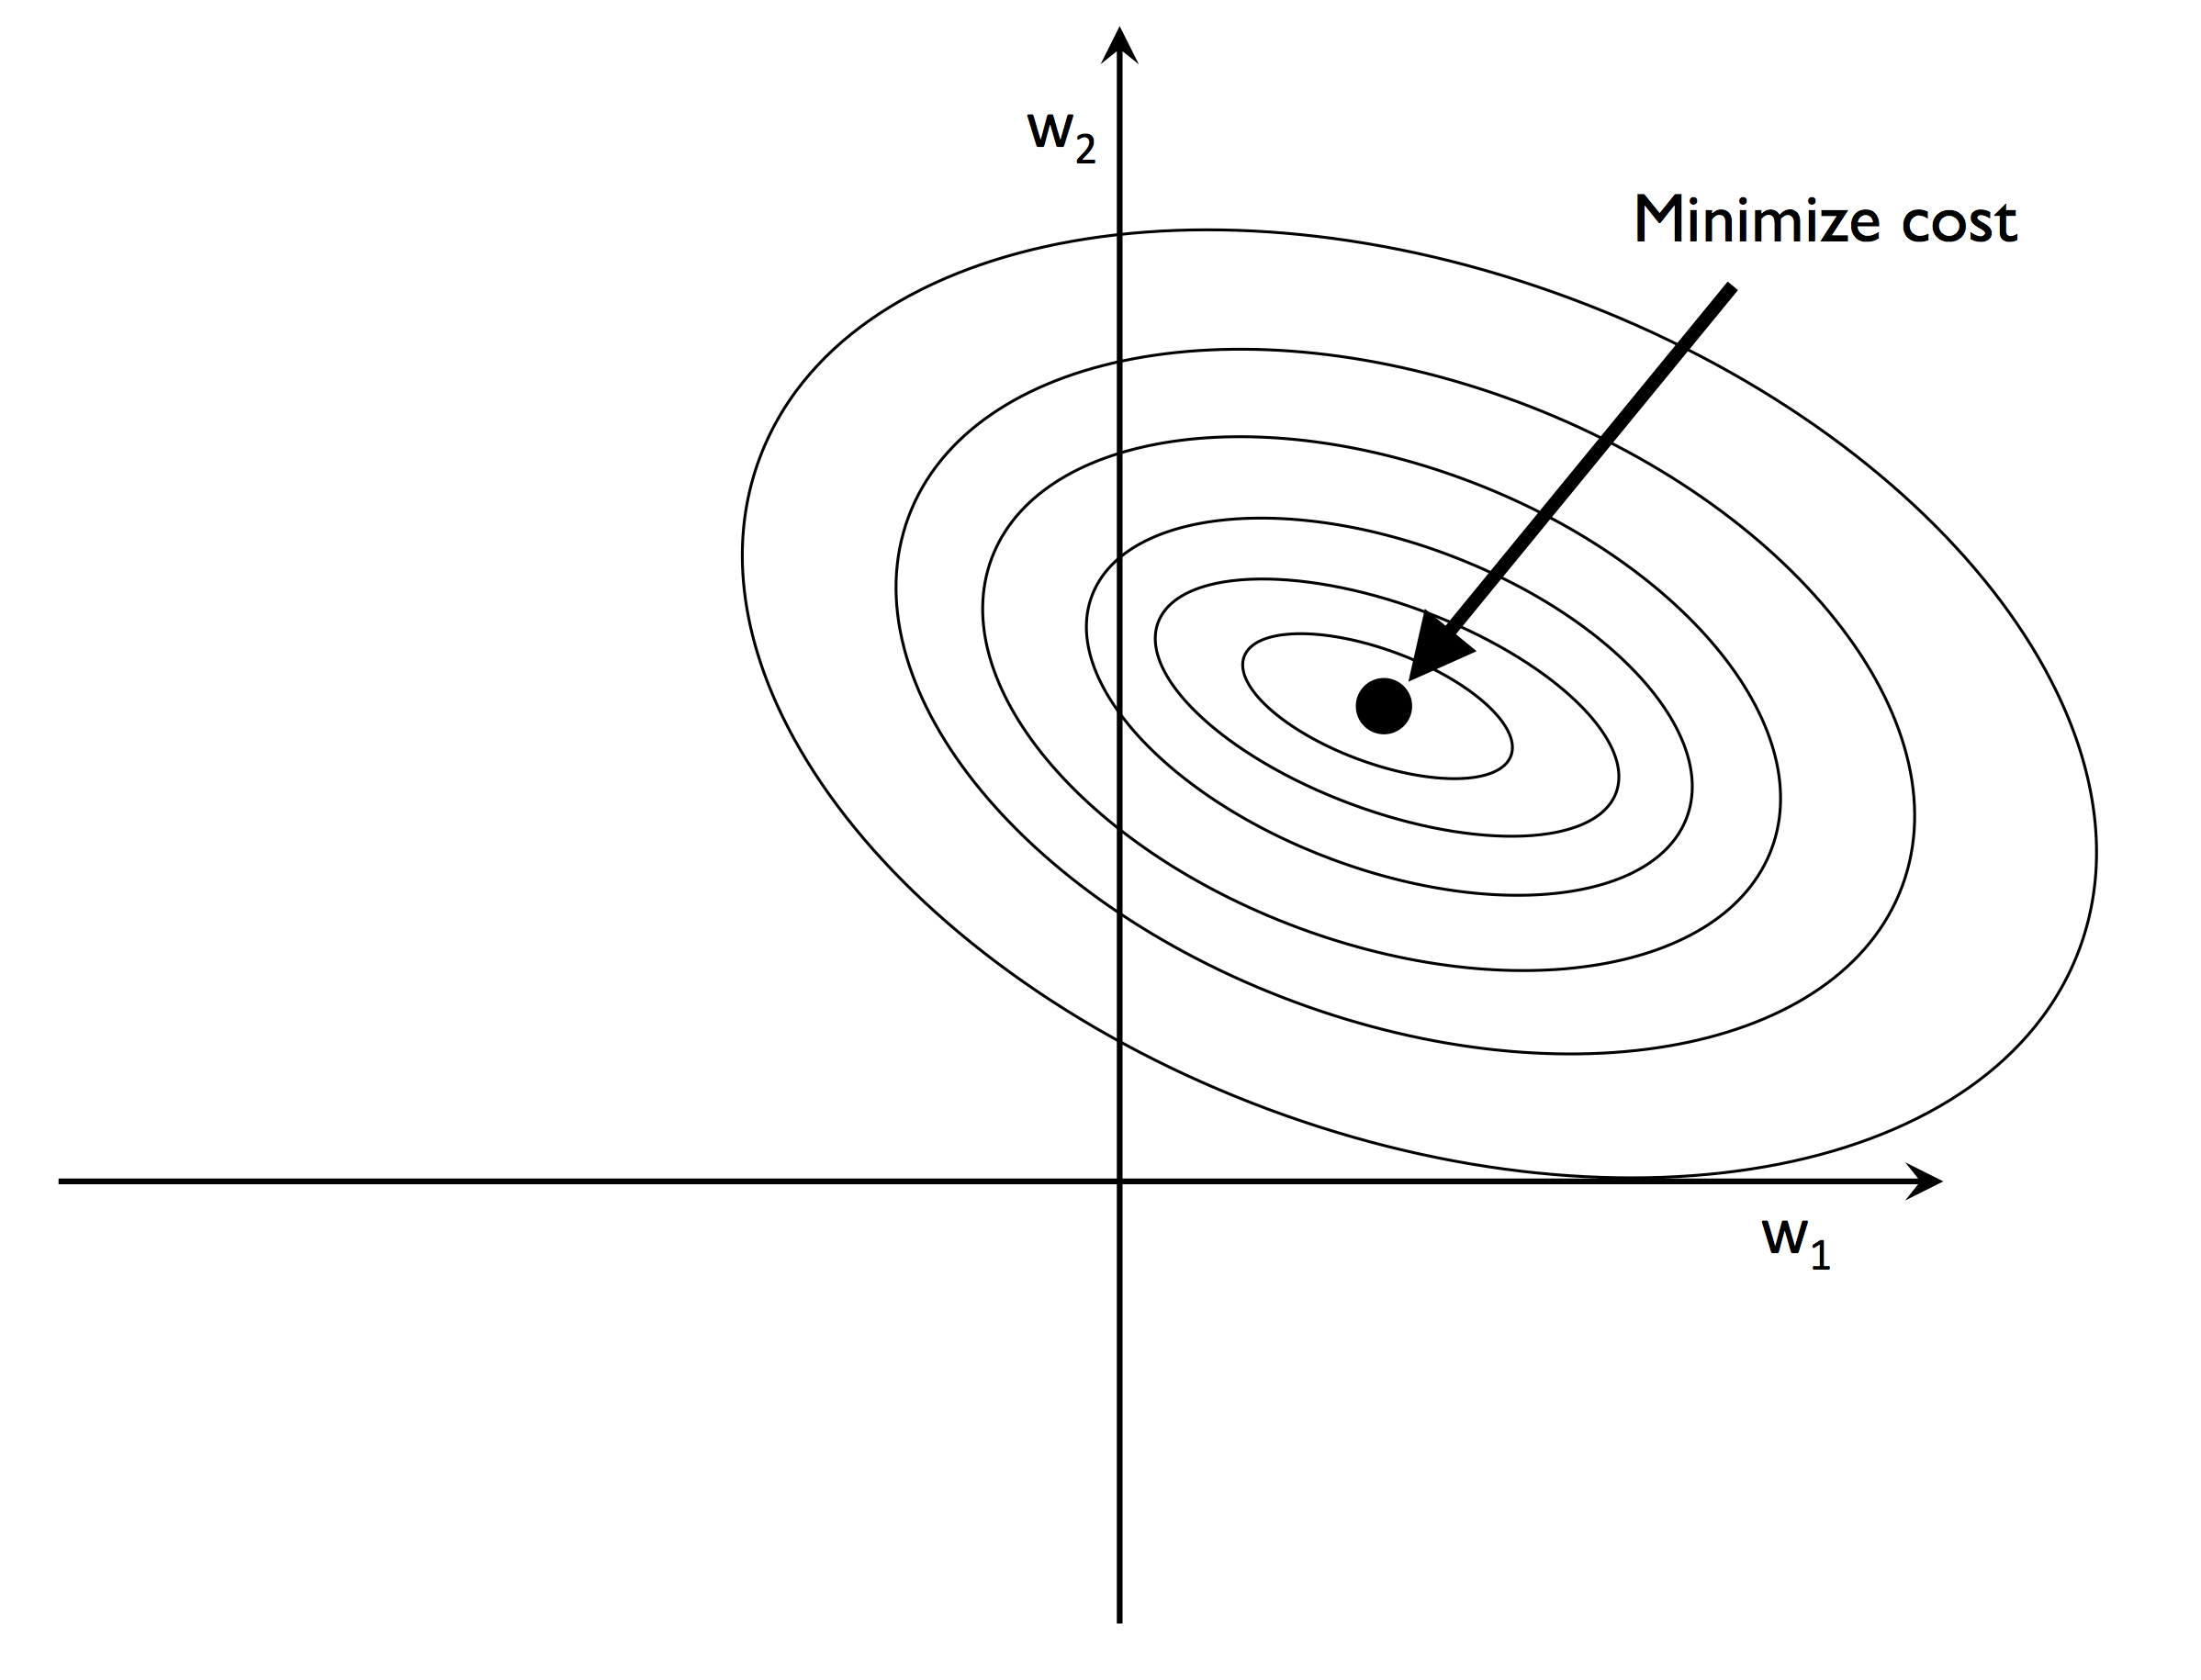

In [35]:
Image(filename='images/04_04.png', width=500) 

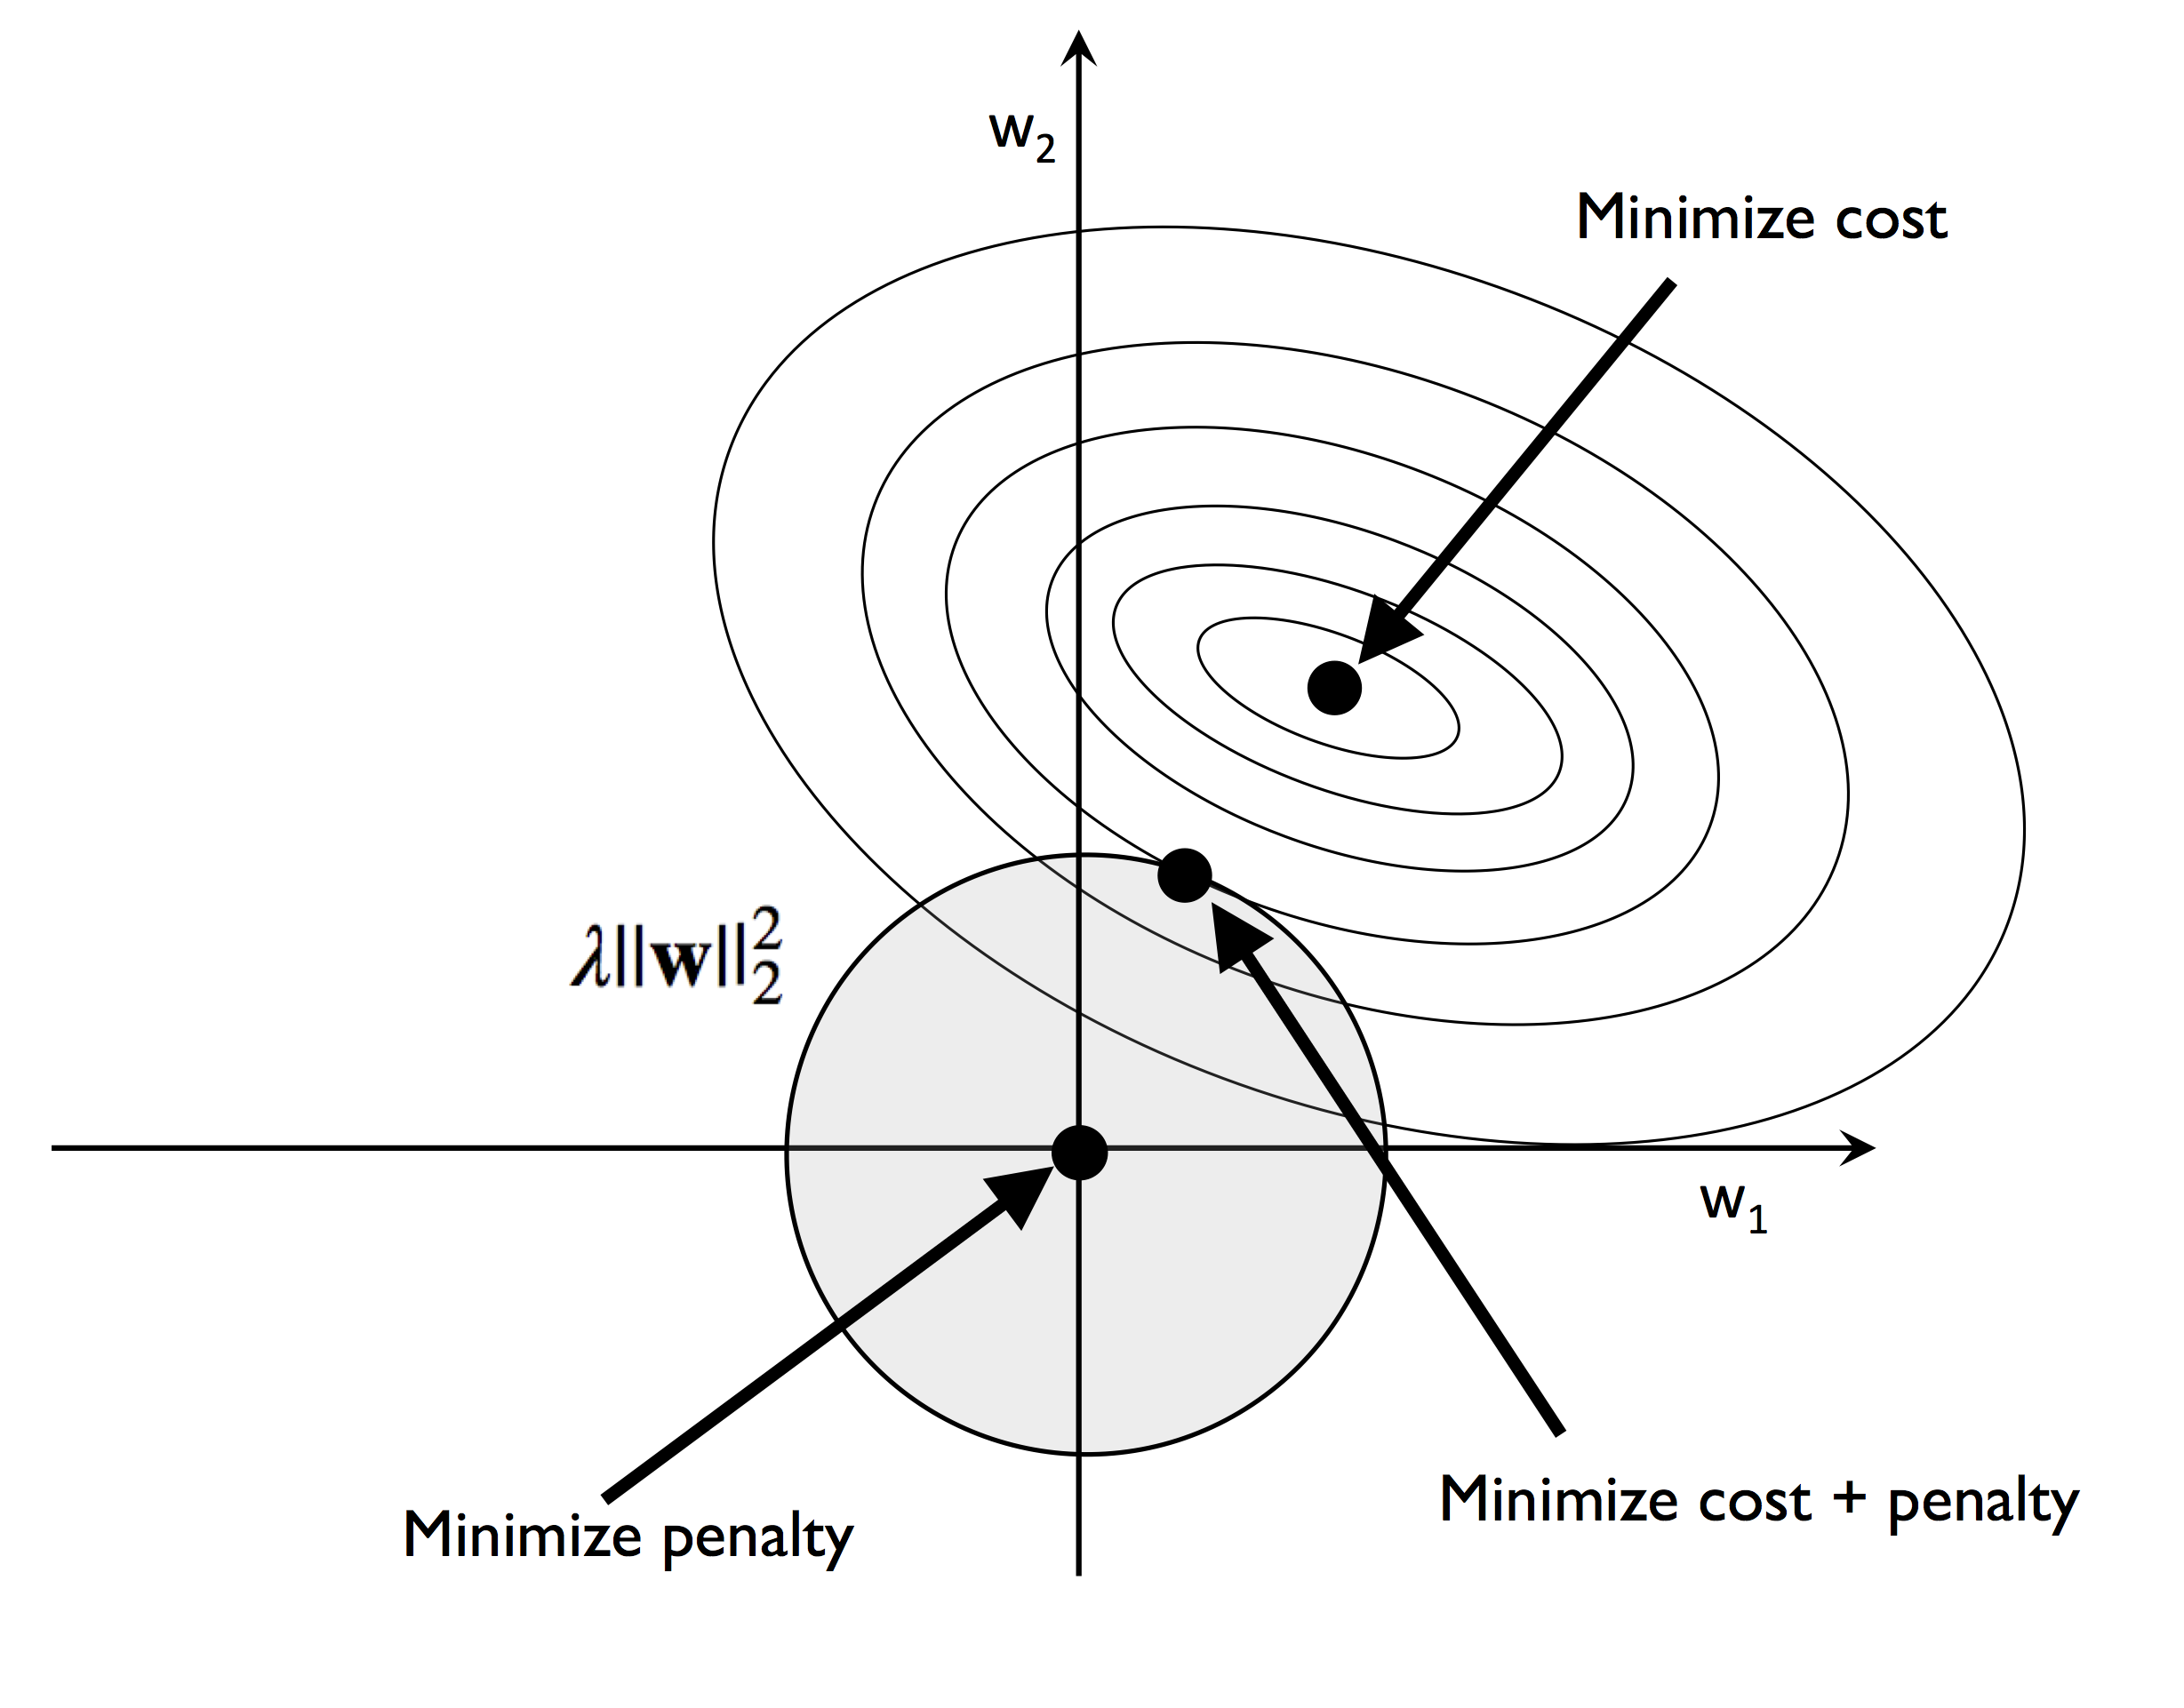

In [36]:
Image(filename='images/04_05.png', width=500) 

## Sparse solutions with L1-regularization

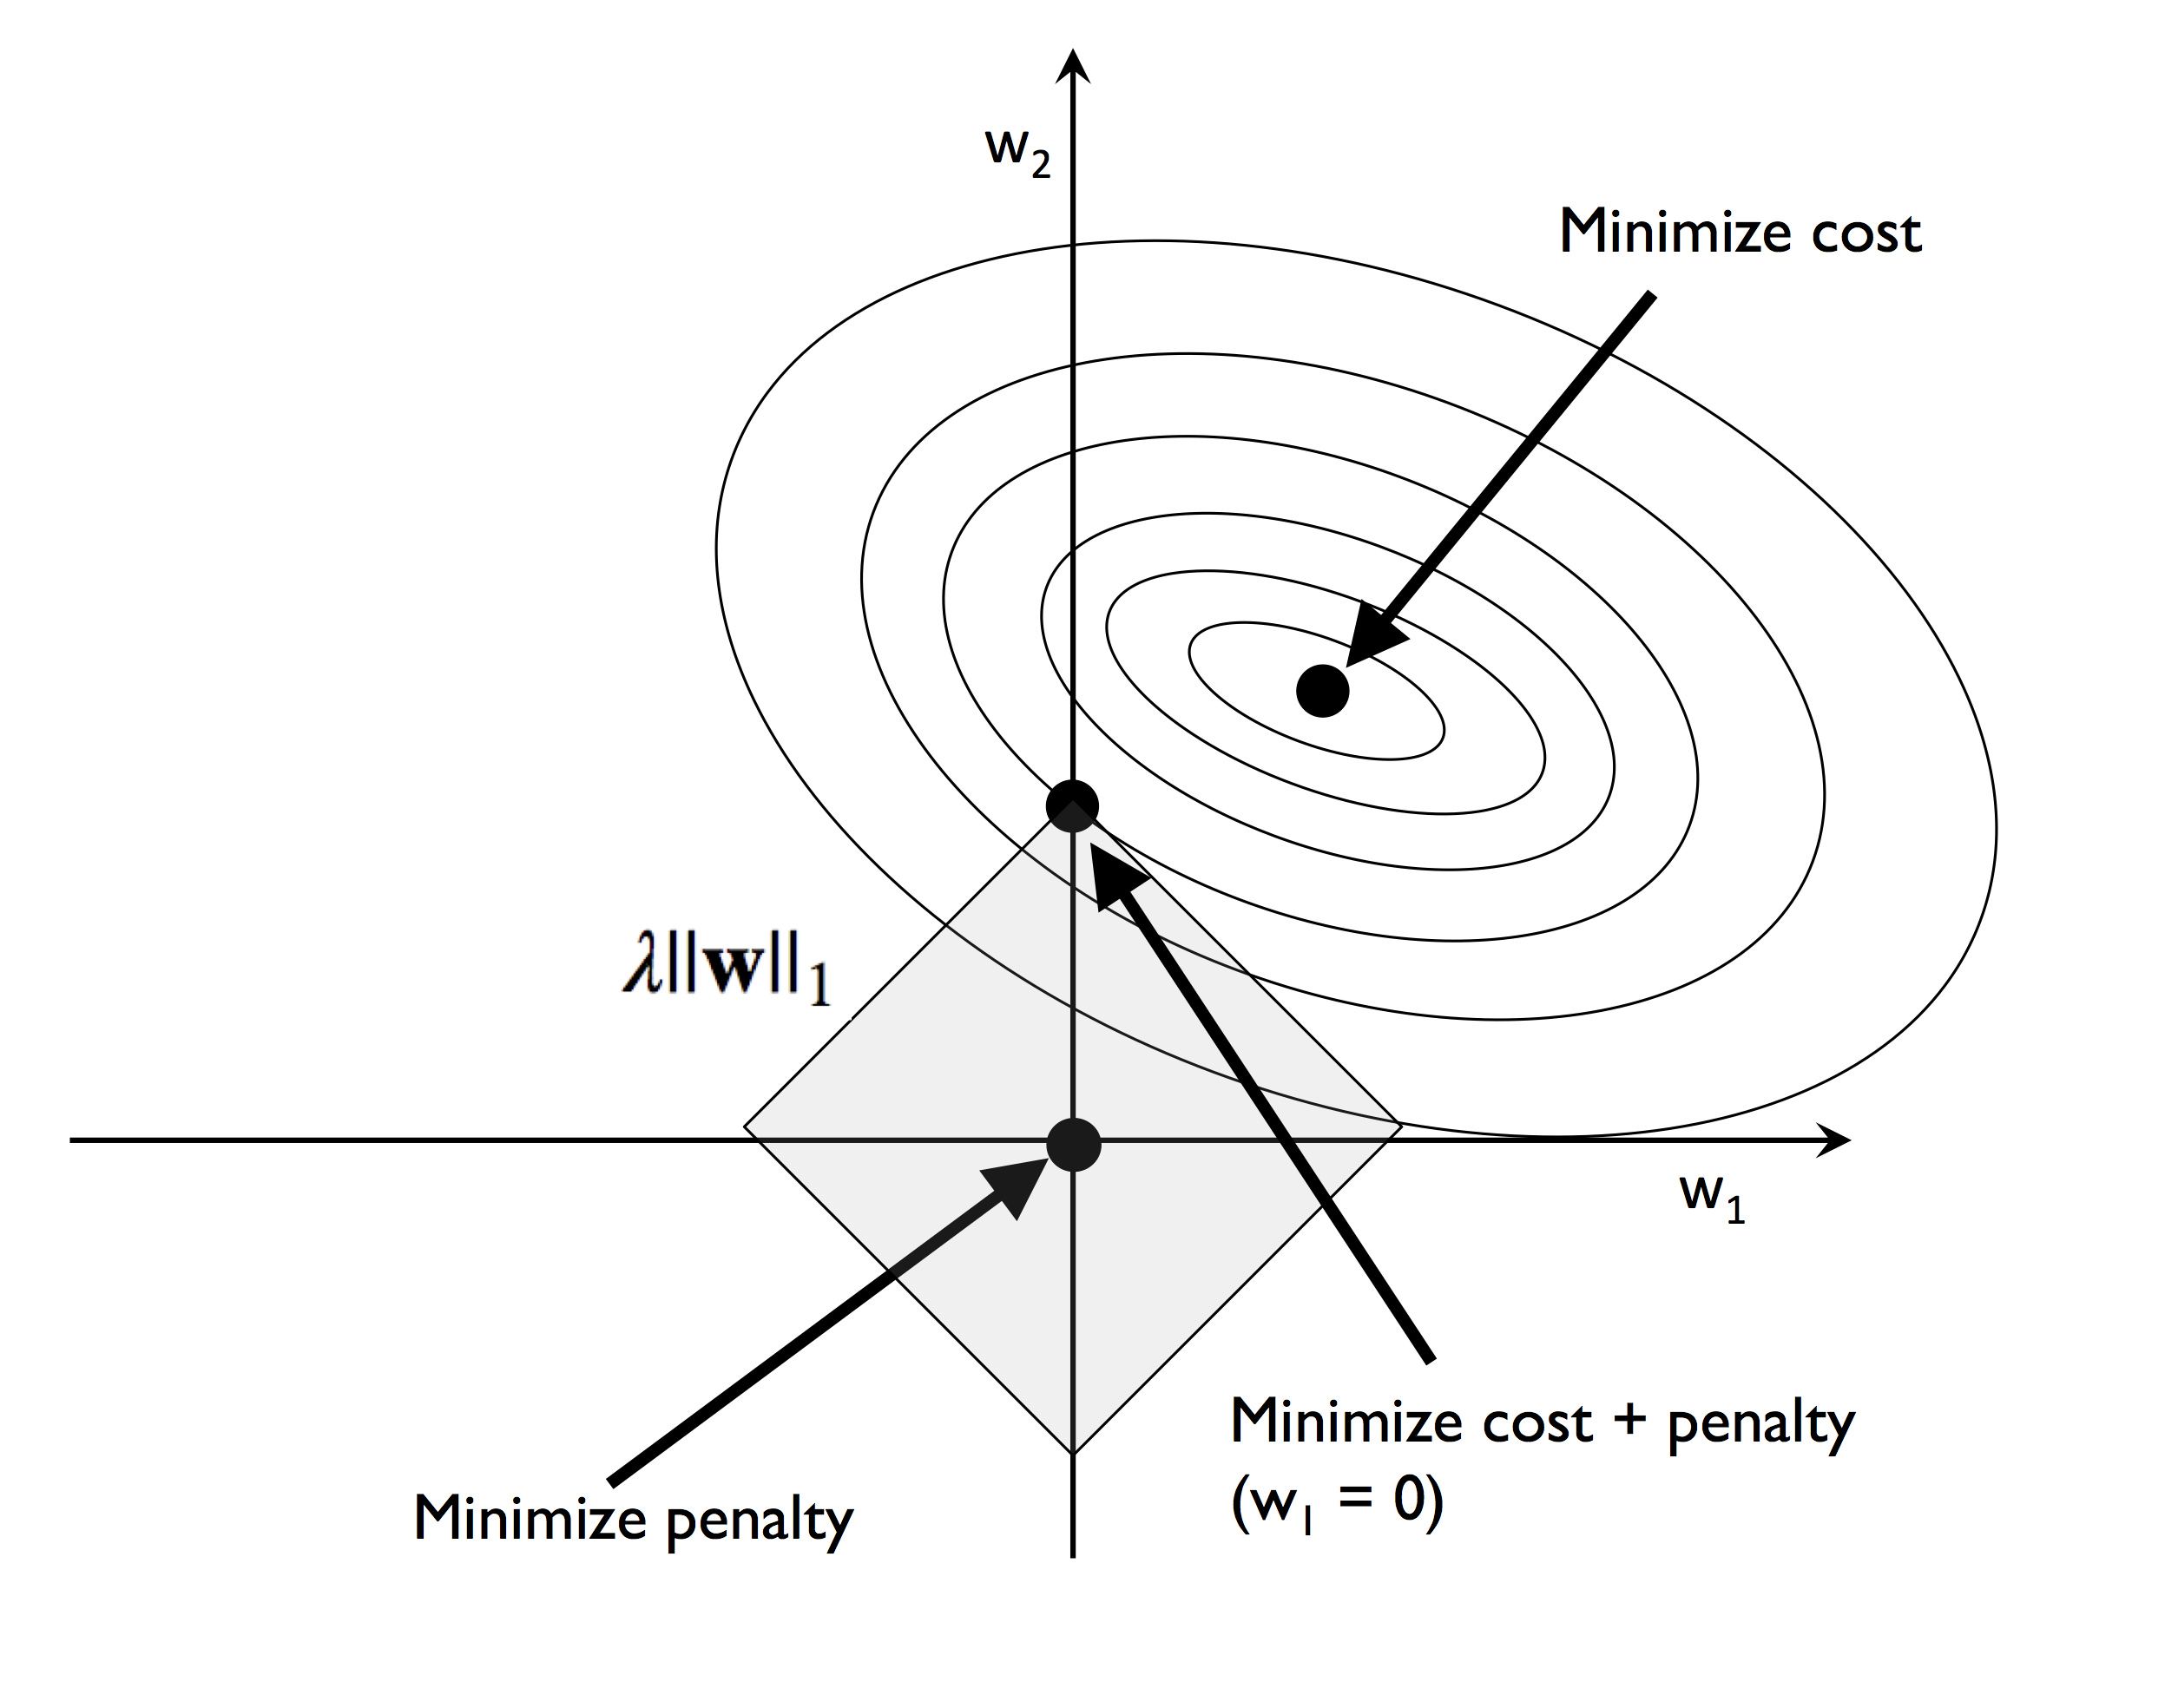

In [37]:
Image(filename='images/04_06.png', width=500) 

For regularized models in scikit-learn that support L1 regularization, we can simply set the `penalty` parameter to `'l1'` to obtain a sparse solution:

In [38]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Applied to the standardized Wine data ...

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0)
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


In [40]:
lr.intercept_

array([-1.26361291, -1.216146  , -2.37102122])

In [41]:
np.set_printoptions(8)

In [42]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [43]:
lr.coef_

array([[ 1.2457521 ,  0.18056423,  0.7450209 , -1.16271735,  0.        ,
         0.        ,  1.1645803 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55242778,  2.50967496],
       [-1.53662345, -0.38759171, -0.99530581,  0.36518204, -0.05957915,
         0.        ,  0.66821534,  0.        ,  0.        , -1.93442184,
         1.23348573,  0.        , -2.23215486],
       [ 0.13488777,  0.16950069,  0.35776952,  0.        ,  0.        ,
         0.        , -2.43358025,  0.        ,  0.        ,  1.56191047,
        -0.8176746 , -0.49726208,  0.        ]])

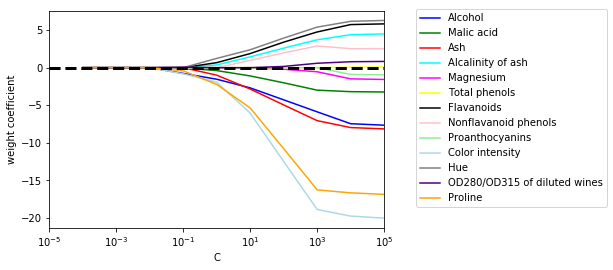

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
#plt.savefig('images/04_07.png', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

<br>
<br>

## Sequential feature selection algorithms

In [45]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

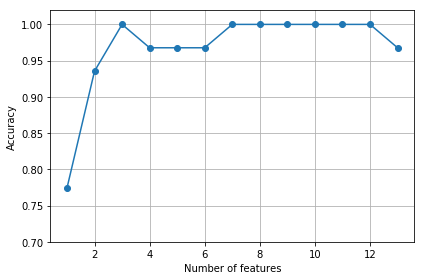

In [46]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [47]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [48]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [49]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


<br>
<br>

# Assessing feature importance with Random Forests

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


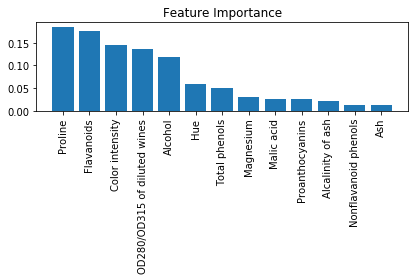

In [50]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

In [51]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


Now, let's print the 3 features that met the threshold criterion for feature selection that we set earlier (note that this code snippet does not appear in the actual book but was added to this notebook later for illustrative purposes):

In [52]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


<br>
<br>

# Summary

...

---

Readers may ignore the next cell.

In [53]:
! python ../.convert_notebook_to_script.py --input ch04.ipynb --output ch04.py

[NbConvertApp] Converting notebook ch04.ipynb to script
[NbConvertApp] Writing 15734 bytes to ch04.py
